In [74]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.graph import grid_to_graph, graph_to_grid

In [75]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.lin1_1 = torch.nn.Linear(13, 26)
        self.lin1_2 = torch.nn.Linear(26, 26)
        self.conv1 = GCNConv(26, 26)
        self.conv2 = GCNConv(26, 26)
        self.lin2_1 = torch.nn.Linear(3 * 26, 3 * 26)
        self.lin2_2 = torch.nn.Linear(3 * 26, 1)

    def forward(self, data):
        x, edge_index, mask, batch = data.x, data.edge_index, data.mask, data.batch

        x = F.relu(self.lin1_1(x))
        x = F.relu(self.lin1_2(x))

        x_neighbors = F.relu(self.conv1(x, edge_index))
        x_neighbors = F.relu(self.conv2(x_neighbors, edge_index))

        x_global = global_mean_pool(x, batch)

        x = torch.cat([x, x_neighbors, x_global.repeat(x.shape[0], 1)], dim=1)
        
        x = F.relu(self.lin2_1(x))
        logits = self.lin2_2(x)
        masked_logits = logits.clone()
        masked_logits[~mask] = -1e12
        return masked_logits

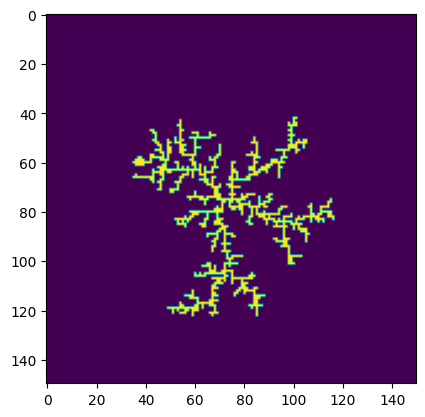

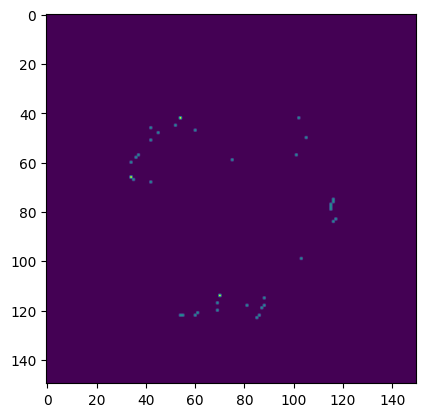

In [76]:
grid_df = pd.read_parquet('../data/0b362cee-93de-4351-a234-a3513a304d1c_grid.parquet')
grid = grid_df.iloc[-1].to_numpy().reshape(150, 150)
distribution_df = pd.read_parquet('../data/0b362cee-93de-4351-a234-a3513a304d1c_distribution.parquet')
distribution = distribution_df.iloc[-1].to_numpy().reshape(150, 150)

plt.imshow(grid)
plt.show()
plt.imshow(distribution);

In [77]:
node_positions, edges, mask, input_nodes, target_nodes = grid_to_graph(grid, distribution)

In [78]:
data = Data(x=torch.tensor(input_nodes, dtype=torch.float), edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(), y=torch.tensor(target_nodes, dtype=torch.long), pos=torch.tensor(node_positions, dtype=torch.float), mask=torch.tensor(mask, dtype=torch.bool))

1.0000007


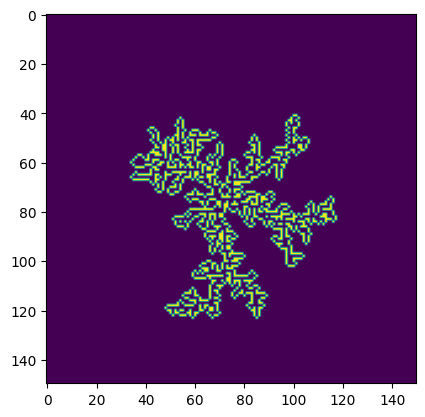

In [83]:
model = GNN()
output_nodes = F.softmax(model(data), dim=0).detach().numpy()
plt.imshow(graph_to_grid(node_positions, output_nodes));